# Обучение эмбеддингов (Metric Learning)
Данные, необходимые для этого модуля:
* symbol_a1.png
* symbol_a2.png
* symbol_b1.png

## Переключение версии TensorFlow

In [1]:
%tensorflow_version 2.x

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
# алгоритм, который отображает многомерные вектора в n-векторные
from sklearn.manifold import TSNE

import tensorflow as tf

## Загрузка и подготовка датасета MNIST

In [3]:
(train_x, train_y), (test_x, test_y) = tf.keras.datasets.mnist.load_data()

train_x = train_x.reshape(-1, 28, 28, 1).astype(np.float32) / 255.
test_x = test_x.reshape(-1, 28, 28, 1).astype(np.float32) / 255.

11501568/11490434 [==============================] - 0s 0us/step


## Визуализация датасета MNIST

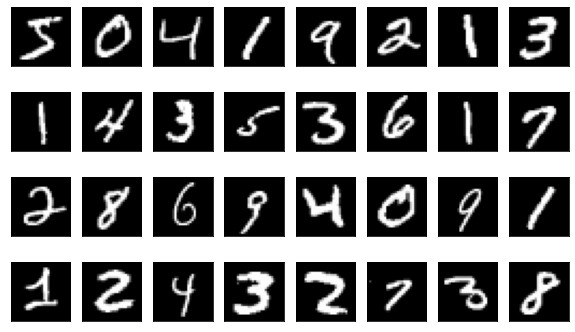

In [4]:
some_samples = train_x[:32, ...]

fig = plt.figure(figsize=(10, 6))
for j in range(some_samples.shape[0]):
    ax = fig.add_subplot(4, 8, j+1)
    ax.imshow(some_samples[j,:,:,0], cmap='gray')
    plt.xticks([]), plt.yticks([])
plt.show()

## Создание модели CNN

Обычная сеть для классификации, но в конце нам нужно получить не распредедение классов, а некоторый вектор(эмбеддинг)

В данном примере мы на выходе получим вектор рразмерности 64, и естественно без функции активации

In [6]:
EMB_SIZE = 64

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    # 
    tf.keras.layers.Dense(EMB_SIZE, activation=None),
])

## Contrastive Loss

Определяется для пары объектов, и имеет 2 ситуации:
- 2 объекта близки друг к другу
- 2 объекта далеки друг от другу

Наша цель: близкие объекты в пространстве эмбеддингом приближать друг к другу, а далекие разносить друг от друга, используя евклидово расстояние

Все зависит от переменной z:
- z = 1 - объекты близки(минимизируем расстояние)
- z = 0 - объекты далеки

MARGIN - порог для определения расстояник(смотри на формулу в return)

In [8]:
MARGIN = 10.0

# подается набор эмбеддингов из картинок и метки классов
def contastive_loss(embs, labels):
    bs = embs.shape[0]
    # разбиваем батч на 2 части
    embs1 = embs[:bs//2, :]
    embs2 = embs[bs//2:, :]
    # тоже делает с метками
    labels1 = labels[:bs//2]
    labels2 = labels[bs//2:]

    # вычитаем эмбеддинги, возводим в квадрат и суммируем вдоль первого измерения
    # (размера эмбеддинга)
    # получаем 32 расстояния (32 пары)
    d2 = tf.reduce_sum(tf.square(embs1 - embs2), axis=1)
    d =  tf.sqrt(d2)
    # находим z
    z = tf.cast(labels1 == labels2, tf.float32)
    # tf.reduce_mean - усреднение по батчу
    return tf.reduce_mean(z * d2 + (1-z) * tf.maximum(0, MARGIN - d)**2)

## Подготовка пайплайна данных

In [9]:
BATCH_SIZE = 64
NUM_EPOCHS = 4

train_ds = tf.data.Dataset.from_tensor_slices((train_x, train_y))
train_ds = train_ds.shuffle(buffer_size=train_x.shape[0])
train_ds = train_ds.repeat(NUM_EPOCHS)
train_ds = train_ds.batch(BATCH_SIZE)

## Подготовка к обучению

In [10]:
LEARNING_RATE = 0.001
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)

## Обучение модели

In [11]:
%%time

for iteration, (images, labels) in enumerate(train_ds):
    
    # Forward
    with tf.GradientTape() as tape:
        embs = model(images)
        loss_value = contastive_loss(embs, labels)
        
    # Backward
    grads = tape.gradient(loss_value, model.variables)
    optimizer.apply_gradients(zip(grads, model.variables))

    if iteration % 200 == 0:
        print('[{}] Loss: {}'.format(iteration, loss_value.numpy()))

[0] Loss: 83.75735473632812
[200] Loss: 6.2259721755981445
[400] Loss: 3.2713356018066406
[600] Loss: 0.11559490114450455
[800] Loss: 3.1131675243377686
[1000] Loss: 3.656883716583252
[1200] Loss: 0.39361149072647095
[1400] Loss: 1.8800718784332275
[1600] Loss: 0.8713966608047485
[1800] Loss: 1.748781442642212
[2000] Loss: 0.7918306589126587
[2200] Loss: 1.7738603353500366
[2400] Loss: 3.055250644683838
[2600] Loss: 0.8212662935256958
[2800] Loss: 0.8276075124740601
[3000] Loss: 1.6136970520019531
[3200] Loss: 4.52725076675415
[3400] Loss: 0.15343482792377472
[3600] Loss: 0.06877081096172333
CPU times: user 57.4 s, sys: 1.51 s, total: 58.9 s
Wall time: 1min 25s


## Получение эмбеддингов для тестовой выборки

In [12]:
test_embs = model(test_x)

## Функция для визуализации эмбеддингов

In [13]:
def draw_embeddings(X_embedded, targets, labels):
    plt.figure(figsize=(10, 10))
    for class_idx in range(np.max(targets)+1):
        X_embedded_class = X_embedded[targets == class_idx, :]
        plt.scatter(X_embedded_class[:,0], X_embedded_class[:,1])
    plt.legend(labels, loc='best')
    plt.grid(True)

## Визуализация образцов MNIST в 2D пространстве с помощью TSNE

In [14]:
test_x_flat = test_x.reshape(-1, 28*28)
# TSNE(n_components=2) - преобразовать в 2-мерное пространство с сохранением расстояния
test_x_2D = TSNE(n_components=2).fit_transform(test_x_flat[:1000])
labels_for_viz = test_y[:1000]

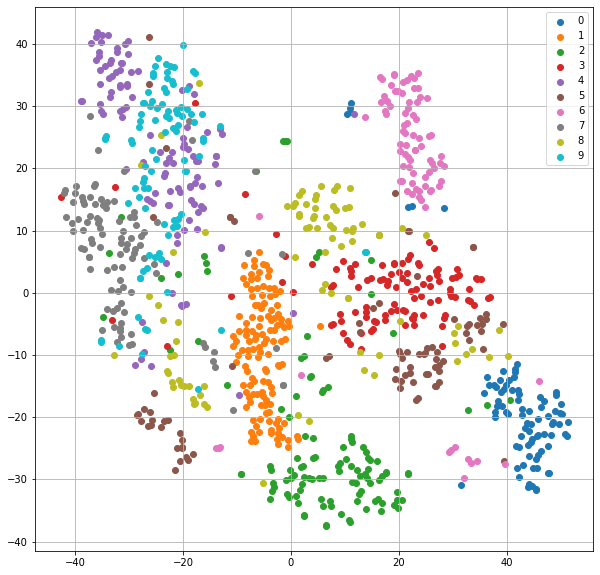

In [15]:
draw_embeddings(test_x_2D, labels_for_viz, list(range(10)))

## Визуализация эмбеддингов в 2D пространстве с помощью TSNE

In [16]:
test_embs_2D = TSNE(n_components=2).fit_transform(test_embs[:1000])
labels_for_viz = test_y[:1000]

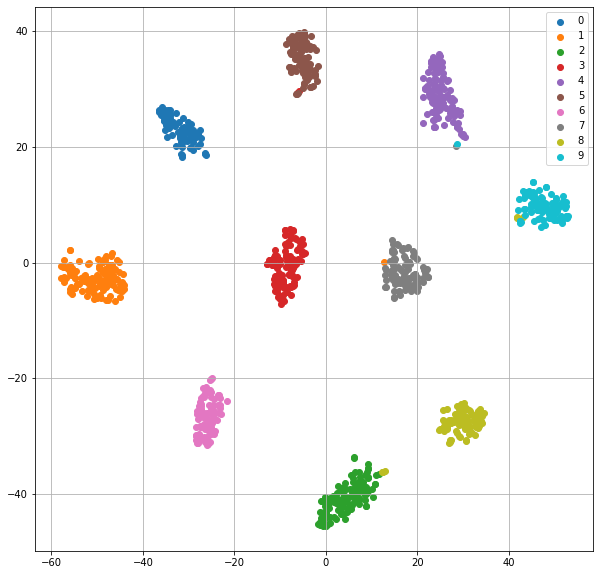

In [17]:
draw_embeddings(test_embs_2D, labels_for_viz, list(range(10)))

## Тестирование на новых данных

Функция просто загружает и преобразует их к определенному виду

In [18]:
def load_and_prepare_image(fpath):
    import imageio
    from skimage.transform import resize
    img = imageio.imread(fpath, pilmode="RGB")
    img = img.astype(np.float32)/255
    img = resize(img, (28, 28), order=3, mode='reflect', anti_aliasing=True)
    img = (1. - img).astype(np.float32)
    img = np.mean(img, axis=2)
    img = np.reshape(img, (28, 28, 1))
    return img

img_a1 = load_and_prepare_image('symbol_a1.png')
img_a2 = load_and_prepare_image('symbol_a2.png')
img_b1 = load_and_prepare_image('symbol_b1.png')

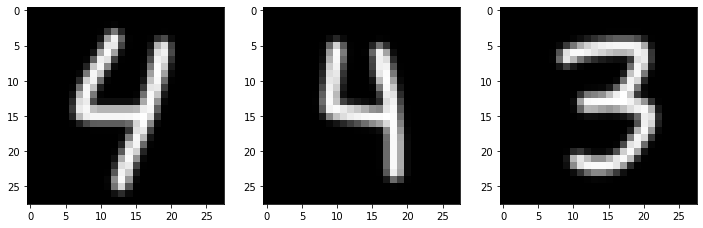

In [19]:
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1, 3, 1)
ax.imshow(img_a1[:,:,0], cmap='gray')
ax = fig.add_subplot(1, 3, 2)
ax.imshow(img_a2[:,:,0], cmap='gray')
ax = fig.add_subplot(1, 3, 3)
ax.imshow(img_b1[:,:,0], cmap='gray')
plt.show()

## Получение эмбеддингов для новых данных

In [20]:
new_embs = model(np.stack((img_a1, img_a2, img_b1), axis=0))

## Вычисление расстояний между эмбеддингами

In [21]:
def diff(e1, e2):
    return np.sum((e1 - e2)**2) ** 0.5

emb1 = new_embs[0,:]
emb2 = new_embs[1,:]
emb3 = new_embs[2,:]

print('A1 <-> A2: ', diff(emb1, emb2))
print('A2 <-> B1: ', diff(emb2, emb3))
print('A1 <-> B1: ', diff(emb1, emb3))

A1 <-> A2:  0.8441749491635173
A2 <-> B1:  15.153014413812036
A1 <-> B1:  14.680007646854914
